In [1]:
import sklearn
import numpy as np

## Sampling From a Gaussian Process

sample fomr the prior Gaussian process.  We first need our covariance function, which is the squared exponential

In [2]:
def exponential_cov(x, y, params):
    return params[0] * np.exp(-0.5*params[1] * np.subtract.outer(x,y)**2)

Next we need the conditional distribution 
$$p(x|y)=N(\mu+\Sigma_{xy}\Sigma_{y}^{-1}(y-\mu),\Sigma_x-\Sigma_{xy}\Sigma_{y}^{-1}\Sigma_{xy}^{T})$$

In [3]:
def conditional(x_new, x, y, params):
    B=exponential_cov(x_new, x, params)
    C=exponential_cov(x, x, params)
    A=exponential_cov(x_new, x_new, params)
    
    mu=np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma=A - B.dot(np.linalg.inv(C).dot(B.T))
    
    return(mu.squeeze(), sigma.squeeze())

<Container object of 3 artists>

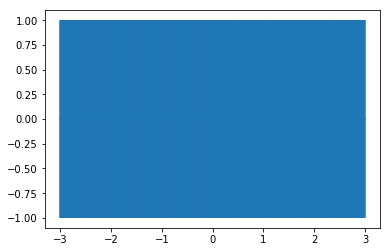

In [4]:
import matplotlib.pylab as plt
%matplotlib inline

theta=[1,10]
sigma_0=exponential_cov(0, 0, theta)
xpts=np.arange(-3,3, step=0.01)
plt.errorbar(x=xpts, y=np.zeros(len(xpts)), yerr=sigma_0, capsize=0)

In [5]:
x=[1.]
y=[np.random.normal(scale=sigma_0)]
y

[0.9538324369450045]

In [6]:
sigma_1 = exponential_cov(x, x, theta)

def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, theta, sigma_1, y) for i in x_pred]

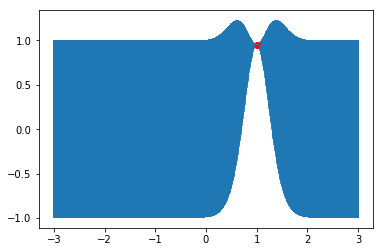

In [7]:
%matplotlib inline

y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

In [8]:
m, s = conditional([-0.7],x,y,theta)
y2 = np.random.normal(m, s)
y2

0.3220644147682397

So conditional on this point, and the covariance structure we have specified, we have essentially constrained the probable location of additional points. Let's now sample another:

In [9]:
x.append(-0.7)
y.append(y2)

sigma_2=exponential_cov(x,x,theta)
predictions=[predict(i,x, exponential_cov, theta, sigma_2, y) for i in x_pred]

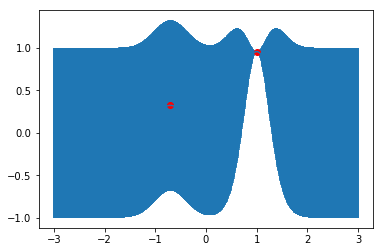

In [10]:
%matplotlib inline

y_pred, sigma = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

In [11]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, theta)
y_more = np.random.multivariate_normal(mu, s)
y_more

array([-0.77972927, -1.76217527, -0.28600615, -0.77391438,  0.44047632])

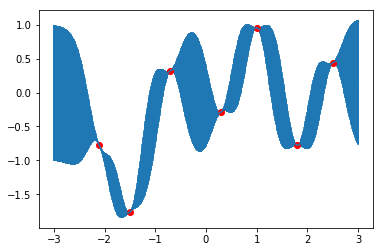

In [12]:
x += x_more
y += y_more.tolist()

sigma_new = exponential_cov(x, x, theta)
predictions = [predict(i, x, exponential_cov, theta, sigma_new, y) for i in x_pred]

y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")

## Fitting Gaussian Process in Python
Three packages for GP modeling:
- scikit-learn
- GPflow
- PyMC3

### sklearn

In [13]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

In [14]:
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

x = np.random.rand(25)
mu, s = conditional(x_more, x, y, theta)
y_more = np.random.multivariate_normal(mu, s)
x

ValueError: shapes (5,25) and (7,) not aligned: 25 (dim 1) != 7 (dim 0)

In [15]:
X = x.reshape(-1, 1)
X.shape

(25, 1)

In [16]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X, y)

ValueError: Found input variables with inconsistent numbers of samples: [25, 7]

In [17]:
gaussian_process.GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1), n_restarts_optimizer=0, normalize_y=False, optimizer='fmin_l_bfgs_b', random_state=None)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [18]:
x_pred = np.linspace(-6, 6).reshape(-1,1)
y_pred, sigma = gp.predict(x_pred, return_std=True)

ValueError: x and y must have same first dimension, but have shapes (25,) and (7,)

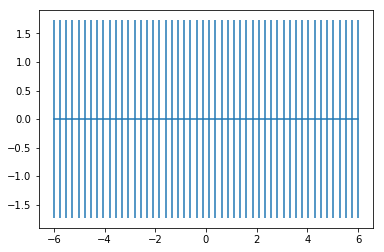

In [19]:
plt.errorbar(x_pred, y_pred, yerr=sigma, capsize=0)
plt.plot(x, y, "ro")

## NeuPy

Hyperparameter optimization of neural networks

### Expected Improvment

$g_{min}(x)=max(0, y_{min} - y_{lowest\ exprected})$

$g_{max}(x)=max(0, y_{highest\ exprected} - y_{max})$

Let’s try to build a hyperparameter optimizer based on Gaussian Process regression and Expected Improvement function. We will continue work with the previous problem where we tried to find the best number of hidden units. But for this time we will try to create a network for digit classification tasks.

Let’s define a function that trains the neural network and return prediction error.

In [20]:
from neupy import algorithms, layers

def train_network(n_hidden, x_train, x_test, y_train, y_test):
    network = algorithms.Momentum(
        [
            layers.Input(64),
            layers.Relu(n_hidden),
            layers.Softmax(10),
        ],

        # Randomly shuffle dataset before each
        # training epoch.
        shuffle_data=True,

        # Do not show training progress in output
        verbose=False,

        step=0.001,
        batch_size=128,
        error='categorical_crossentropy',
    )
    network.train(x_train, y_train, epochs=100)

    # Calculates categorical cross-entropy error between
    # predicted value for x_test and y_test value
    return network.prediction_error(x_test, y_test)

In [21]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from neupy import environment

environment.reproducible()

dataset = datasets.load_digits()
n_samples = dataset.target.size
n_classes = 10

# One-hot encoder
target = np.zeros((n_samples, n_classes))
target[np.arange(n_samples), dataset.target] = 1

x_train, x_test, y_train, y_test = train_test_split(
    dataset.data, target, train_size=0.7
)

In [22]:
import numpy as np
from sklearn.gaussian_process import GaussianProcess

def vector_2d(array):
    return np.array(array).reshape((-1, 1))

def gaussian_process(x_train, y_train, x_test):
    x_train = vector_2d(x_train)
    y_train = vector_2d(y_train)
    x_test = vector_2d(x_test)

    # Train gaussian process
    gp = GaussianProcess(corr='squared_exponential',
                         theta0=1e-1, thetaL=1e-3, thetaU=1)
    gp.fit(x_train, y_train)

    # Get mean and standard deviation for each possible
    # number of hidden units
    y_mean, y_var = gp.predict(x_test, eval_MSE=True)
    y_std = np.sqrt(vector_2d(y_var))

    return y_mean, y_std

In [23]:
def next_parameter_by_ei(y_min, y_mean, y_std, x_choices):
    # Calculate expecte improvement from 95% confidence interval
    expected_improvement = y_min - (y_mean - 1.96 * y_std)
    expected_improvement[expected_improvement < 0] = 0

    max_index = expected_improvement.argmax()
    # Select next choice
    next_parameter = x_choices[max_index]

    return next_parameter

In [24]:
import random

def hyperparam_selection(func, n_hidden_range, func_args=None, n_iter=20):
    if func_args is None:
        func_args = []

    scores = []
    parameters = []

    min_n_hidden, max_n_hidden = n_hidden_range
    n_hidden_choices = np.arange(min_n_hidden, max_n_hidden + 1)

    # To be able to perform gaussian process we need to
    # have at least 2 samples.
    n_hidden = random.randint(min_n_hidden, max_n_hidden)
    score = func(n_hidden, *func_args)

    parameters.append(n_hidden)
    scores.append(score)

    n_hidden = random.randint(min_n_hidden, max_n_hidden)

    for iteration in range(2, n_iter + 1):
        score = func(n_hidden, *func_args)

        parameters.append(n_hidden)
        scores.append(score)

        y_min = min(scores)
        y_mean, y_std = gaussian_process(parameters, scores,
                                         n_hidden_choices)

        n_hidden = next_parameter_by_ei(y_min, y_mean, y_std,
                                        n_hidden_choices)

        if y_min == 0 or n_hidden in parameters:
            # Lowest expected improvement value have been achieved
            break

    min_score_index = np.argmin(scores)
    return parameters[min_score_index]

In [26]:
best_n_hidden = hyperparam_selection(
    train_network,
    n_hidden_range=[50, 1000],
    func_args=[x_train, x_test, y_train, y_test],
    n_iter=6,
)

/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GaussianProcess is deprecated; GaussianProcess was deprecated in version 0.18 and will be removed in 0.20. Use the GaussianProcessRegressor instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_distances was deprecated in version 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GaussianProcess is deprecated; GaussianProcess was deprecated in version 0.18 and will be removed in 0.20. Use the GaussianProcessRegressor instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_di

In [28]:
best_n_hidden

1000